In [ ]:

!wget https://github.com/todn0320/breast_Ultrasound_image/raw/main/Dataset_BUSI_with_GT.z01
!wget https://github.com/todn0320/breast_Ultrasound_image/raw/main/Dataset_BUSI_with_GT.zip

!zip -F /content/Dataset_BUSI_with_GT.zip --out /content/Dataset_BUSI_with_GT_total.zip
!unzip Dataset_BUSI_with_GT_total.zip

--2024-06-10 15:12:39--  https://github.com/todn0320/breast_Ultrasound_image/raw/main/Dataset_BUSI_with_GT.z01
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/todn0320/breast_Ultrasound_image/main/Dataset_BUSI_with_GT.z01 [following]
--2024-06-10 15:12:39--  https://raw.githubusercontent.com/todn0320/breast_Ultrasound_image/main/Dataset_BUSI_with_GT.z01
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104857600 (100M) [application/octet-stream]
Saving to: ‘Dataset_BUSI_with_GT.z01’

Dataset_BUSI_with_G 100%[===================>] 100.00M   269MB/s    in 0.4s    

2024-06-10 15:12:42 (269 MB/s) - ‘

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torchvision.transforms.functional as F
from torchvision import transforms

image_size = (224,224)

# Define a transform to convert images to RGB
convert_to_rgb = transforms.Lambda(lambda image: image.convert('RGB'))

train_transform = transforms.Compose([
    convert_to_rgb,
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),  # Add random horizontal flip
    transforms.RandomVerticalFlip(p=0.5),    # Add random vertical flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Add color jitter
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    convert_to_rgb,
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
EPOCHS = 100
#batch size can also be a learnable hyperparameter, but it was not included in the grid search
BATCH_SIZE = 16

In [ ]:
#Load and view images and labels
import torch
import torchvision
from torchvision.transforms import ToTensor
from PIL import ImageDraw, ImageFont, Image
import matplotlib.pyplot as plt
import random

# Function to exclude mask files
def is_not_mask(filename):
    return not filename.endswith('_mask.png')

# Load the dataset, excluding mask files
ds = torchvision.datasets.ImageFolder('/content/Dataset_BUSI_with_GT', transform=train_transform, is_valid_file=is_not_mask)

print(ds.classes)
print(len(ds))
image, label = ds[0]
#image is channel,
print(image.shape)

['benign', 'malignant', 'normal']
798
torch.Size([3, 224, 224])


In [ ]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
from torch.utils.data import DataLoader, random_split

print("Number of samples: ", len(ds))
print("Detected Classes are: ", ds.class_to_idx)

# Calculate the sizes of the splits
train_size = int(0.7 * len(ds)) # 70% for training
val_size = int(0.15 * len(ds)) # 15% for validation
test_size = len(ds) - train_size - val_size # 15% for testing

# Split the dataset into training, validation, and testing sets
train_ds, val_ds, test_ds = random_split(ds, [train_size, val_size, test_size])
print(f"train: {len(train_ds)} test: {len(test_ds)} val: {len(val_ds)}")
# Create DataLoaders for each split
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


Number of samples:  798
Detected Classes are:  {'benign': 0, 'malignant': 1, 'normal': 2}
train: 558 test: 121 val: 119


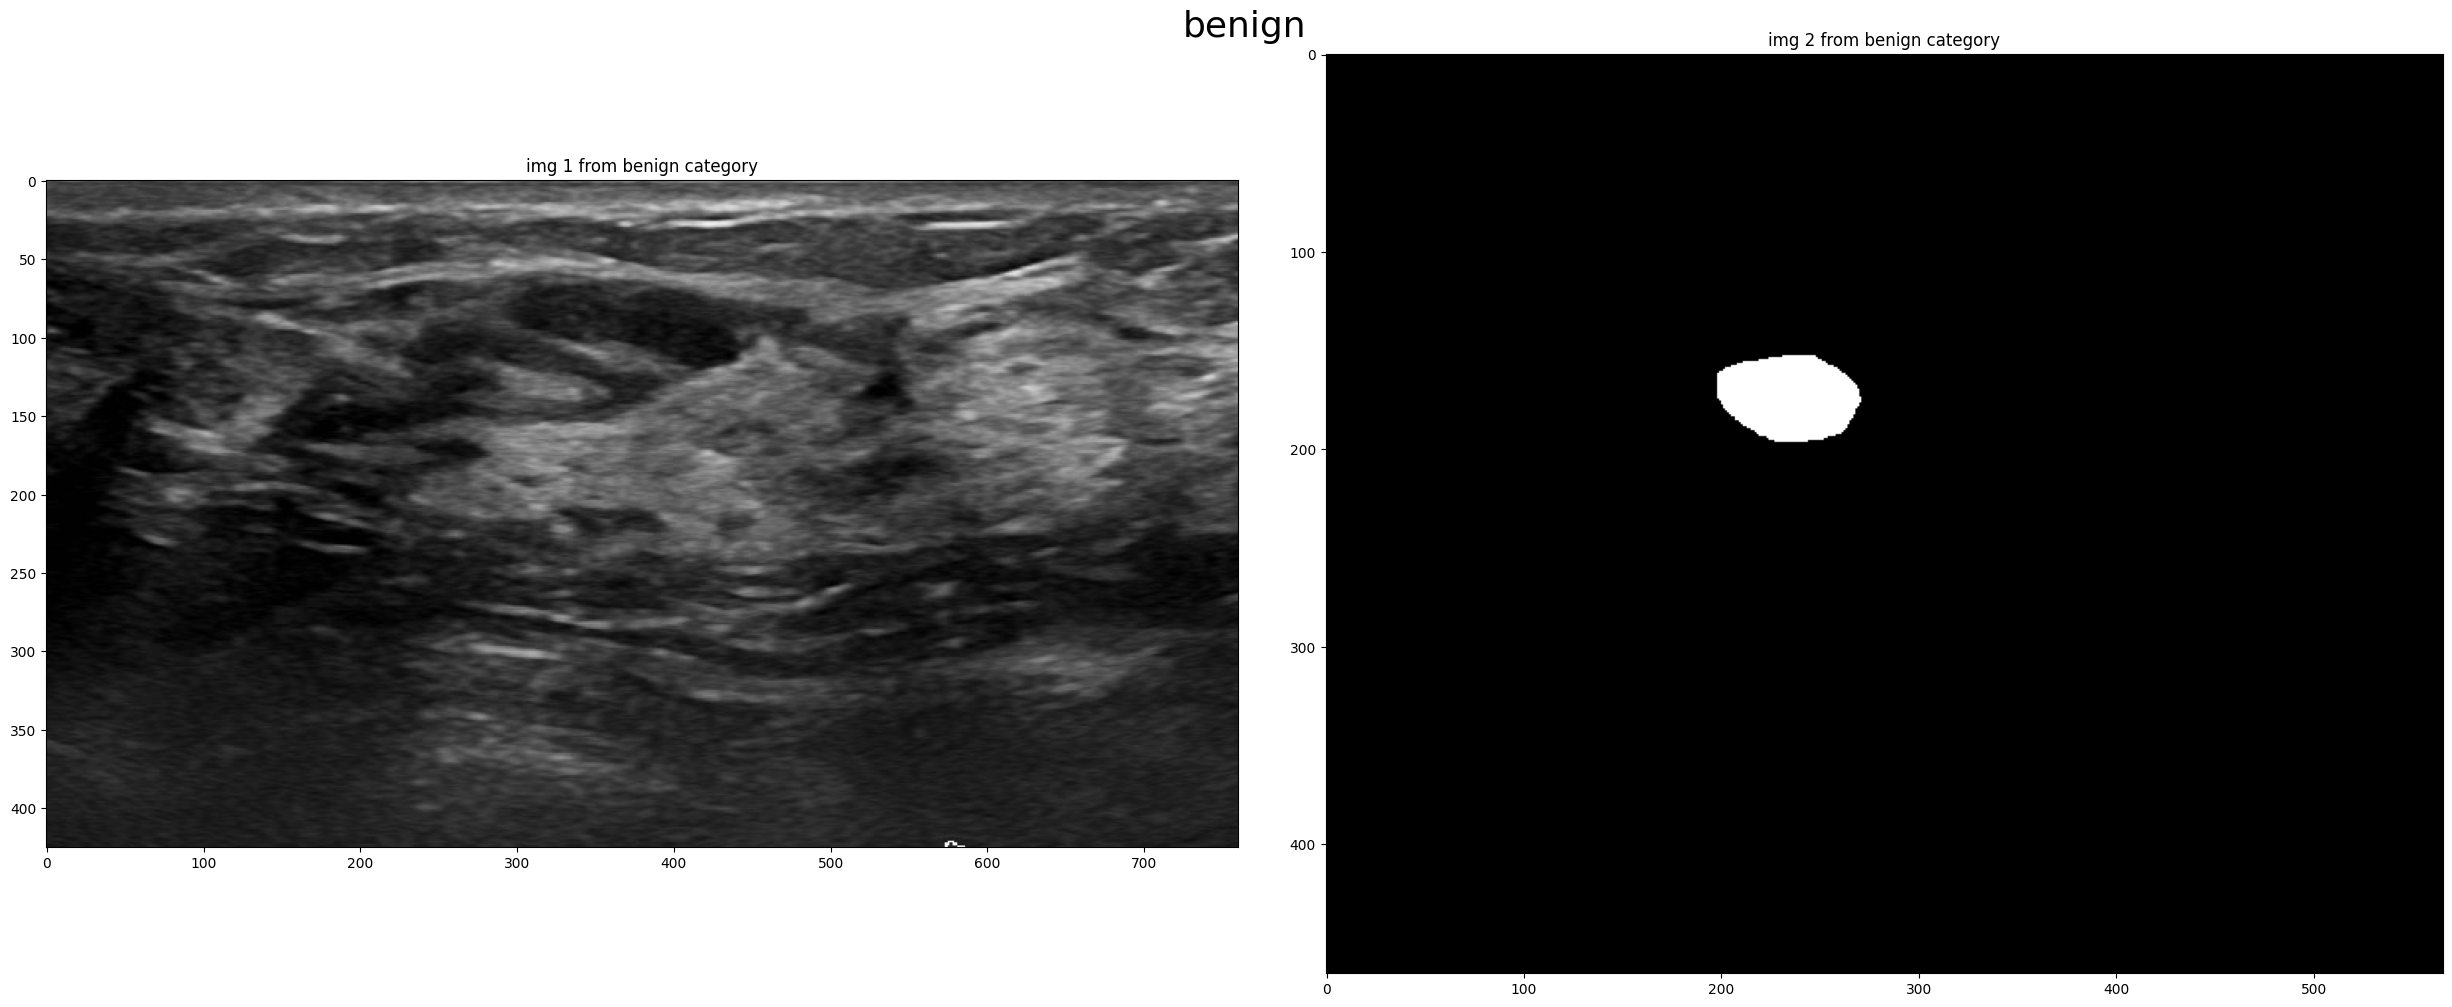

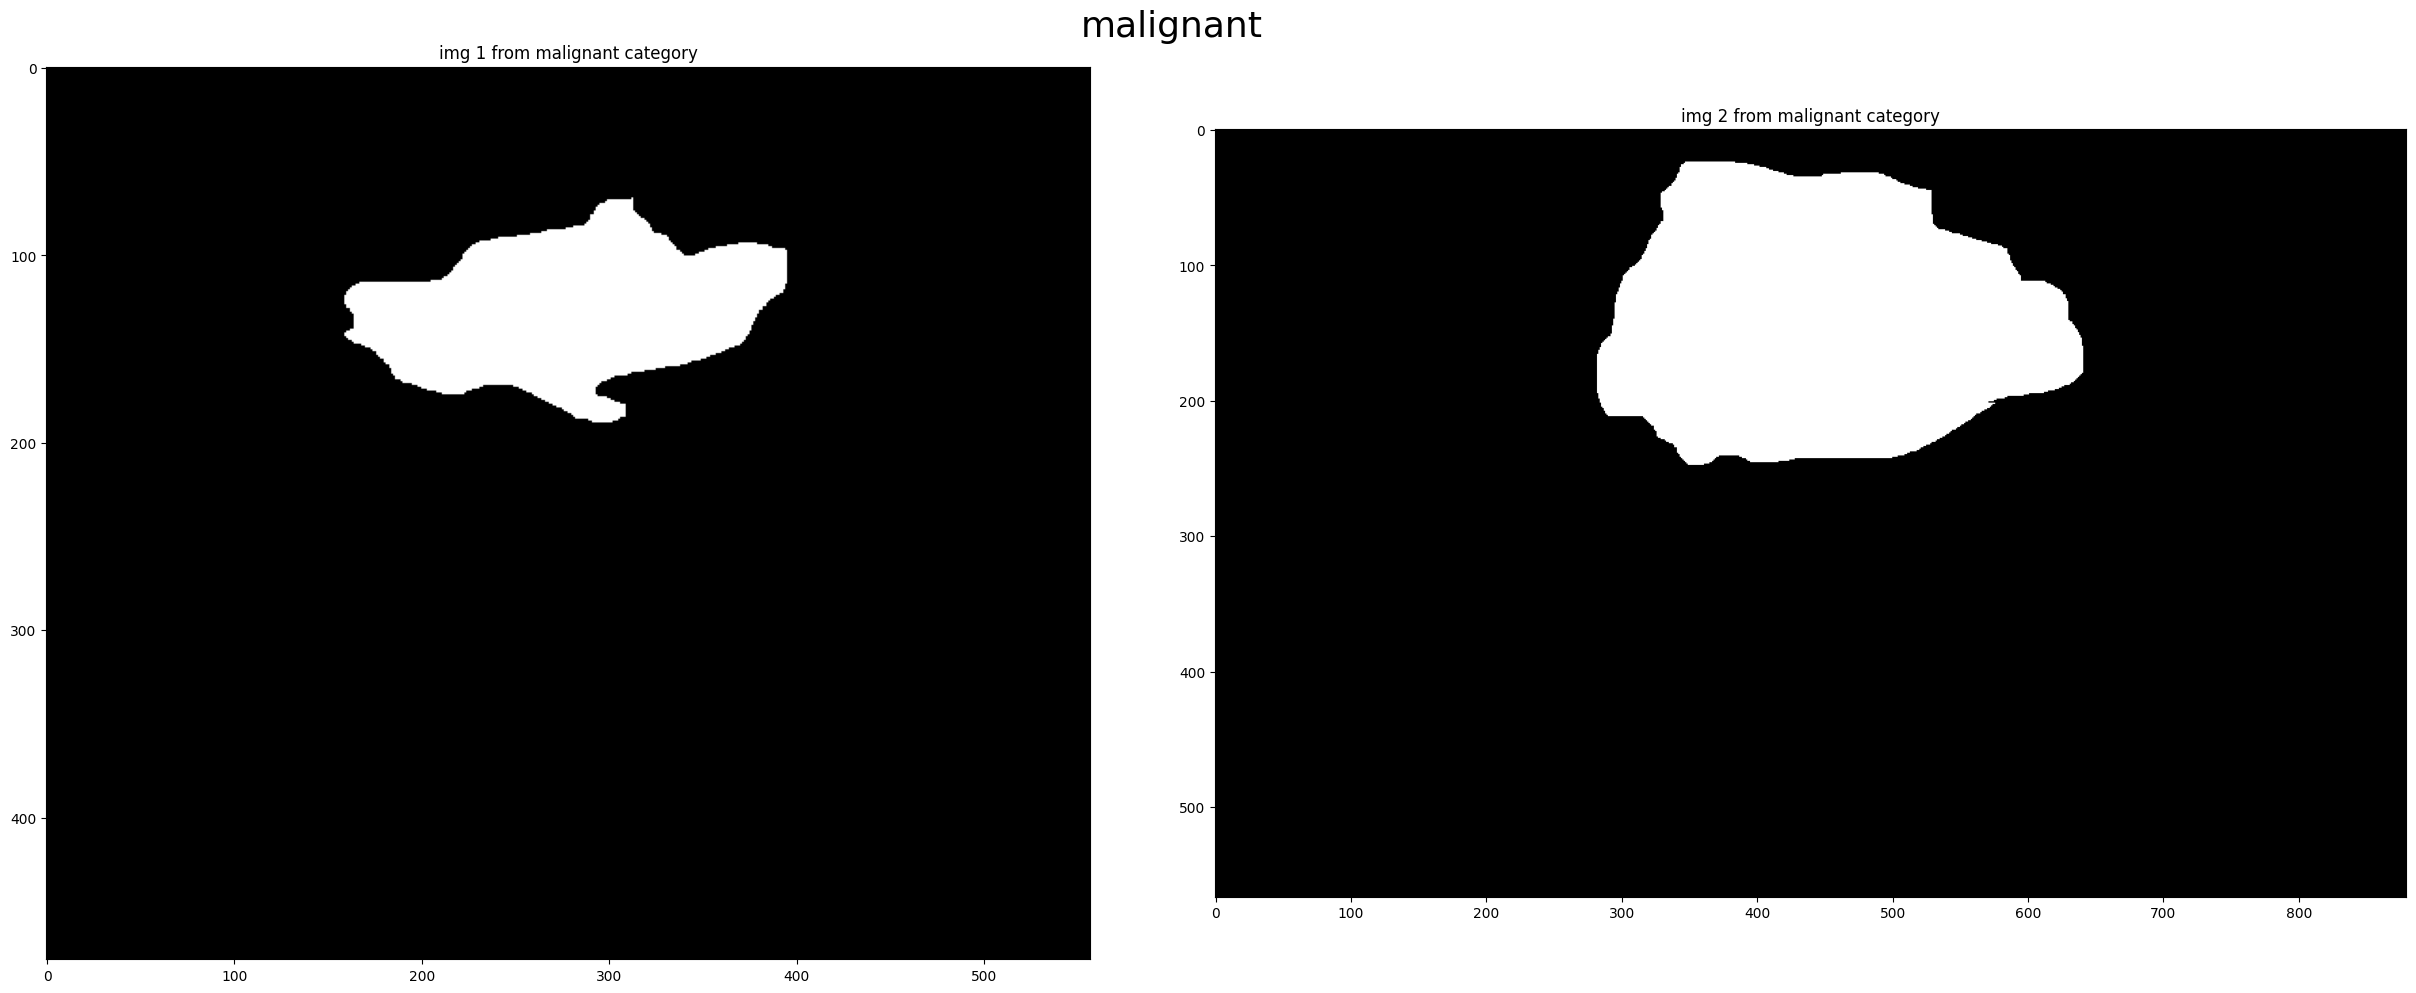

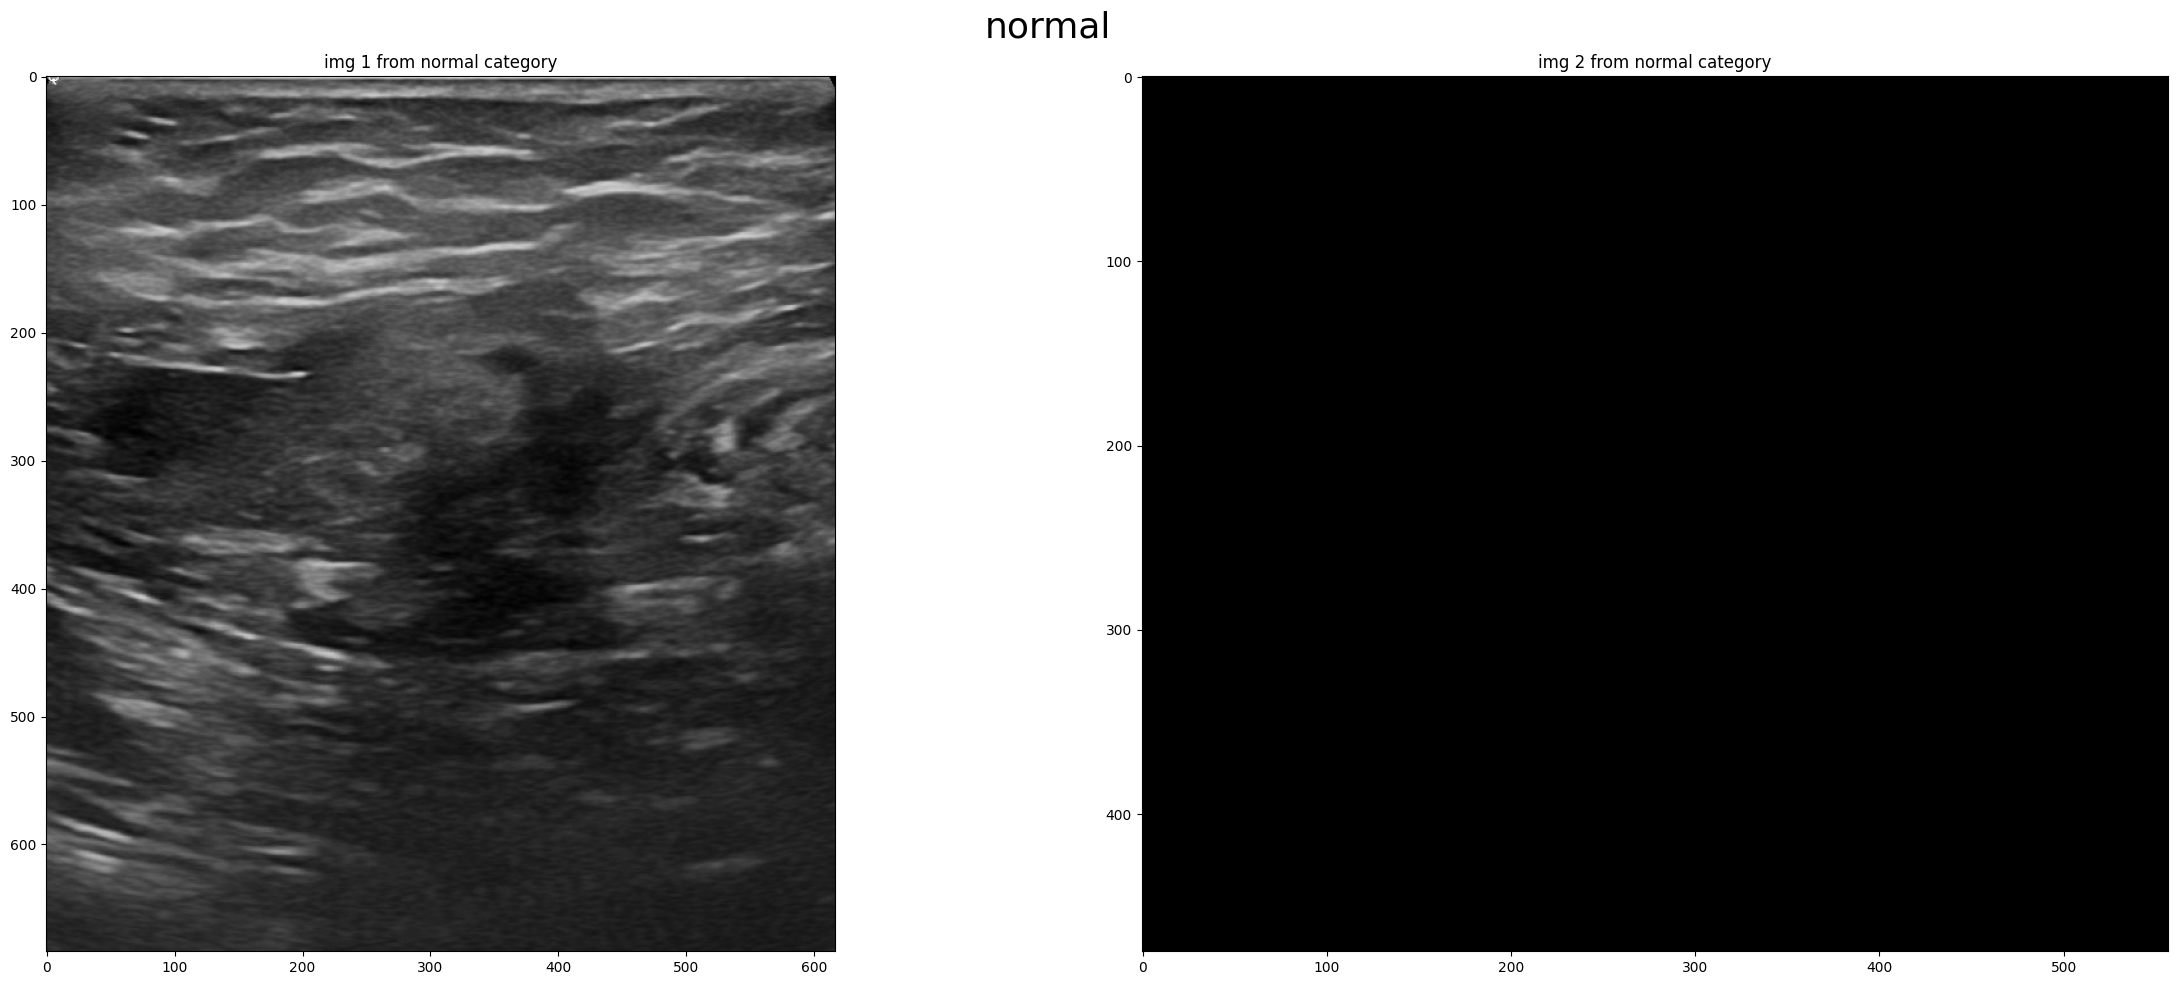

In [ ]:
import os
import cv2

folder_name = '/content/Dataset_BUSI_with_GT'
files_names = ['benign', 'malignant', 'normal']

for file in files_names:
    path = os.path.join(folder_name, file)
    x = 0
    fig, axes = plt.subplots(1,2, figsize=(25, 10))
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        axes[x].imshow(img_array, cmap='gray')
        axes[x].set_title(f"img {x+1} from {file} category")
        x += 1
        if x == 2:
            break

    plt.suptitle(file, fontsize=26)
    plt.tight_layout()
    plt.show()

In [ ]:
def show_examples(train_data_loader, max_normal = 4):

    plt.figure(figsize=(10, 10))
    cnt = 0

    for batch in train_data_loader:
        images, targets = batch
        i = 0
        for i in range(len(images)):
            if targets[i] == 0 and cnt < max_normal:
                ax = plt.subplot(max_normal, max_normal, cnt + 1)
                plt.imshow(images[i].permute(1, 2, 0))
                plt.title(ds.classes[targets[i]])
                cnt += 1
            elif targets[i] == 1 and ((max_normal - 1) < cnt < (max_normal * 2)):
                ax = plt.subplot(max_normal, max_normal, cnt + 1)
                plt.imshow(images[i].permute(1, 2, 0))
                plt.title(ds.classes[targets[i]])
                cnt += 1
            elif targets[i] == 2 and ((max_normal * 2 - 1) < cnt < (max_normal * 3)):
                ax = plt.subplot(max_normal, max_normal, cnt + 1)
                plt.imshow(images[i].permute(1, 2, 0))
                plt.title(ds.classes[targets[i]])
                cnt += 1
        if cnt == (max_normal * 3):
            break


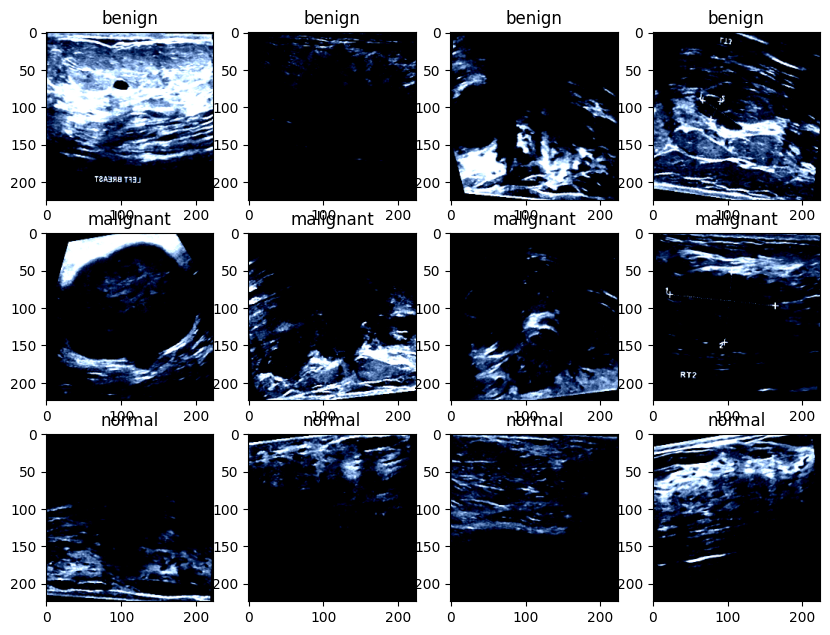

In [ ]:
show_examples(train_loader)

In [ ]:
from transformers import ViTModel
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=3): # Update num_labels to 3 for 3-class classification
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels) # Adjust the output size to match the number of classes
        self.num_labels = num_labels

    def forward(self, pixel_values, labels=None):
        # Apply gradient checkpointing to the ViTModel forward pass
        def vit_forward(pixel_values):
            return self.vit(pixel_values=pixel_values)

        outputs = cp.checkpoint(vit_forward, pixel_values)
        output = outputs.last_hidden_state[:,0]
        logits = self.classifier(output)

        # Calculate probabilities using softmax
        probabilities = F.softmax(logits, dim=1)

        loss = None
        if labels is not None:
            # Use CrossEntropyLoss for multi-class classification
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        if loss is not None:
            return probabilities, loss
        else:
            return probabilities, None

In [ ]:
from transformers import ViTImageProcessor
import torch.nn as nn
import torch
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'learning_rate': [1e-5,1e-4,1e-3,0.001, 0.01, 0.1],
    'weight_decay': [1e-4, 1e-5, 1e-6]
}

# Define Model for 3-class Classification
model = ViTForImageClassification(num_labels=3) # Update to 3 for 3-class classification

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    model.cuda()

# Image Processor
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
# Generate all possible combinations for grid search
param_combinations = list(ParameterGrid(param_grid))
threshold = 0.5
best_param_combo = None
best_train_acc_score = 0
#Uncomment this section to rerun Grid search for a base best model and best optimizer and accuracy score
# Initialize초기화 best hyperparameter combination결합 and best training accuracy
n_total_steps = len(train_loader)
print("Total steps: " + str(n_total_steps))
trainingEpoch_loss = []
validationEpoch_loss = []
trainingEpoch_acc = []
validationEpoch_acc = []
add_epoch = 0
# Iterate over combinations and train/evaluate the model
for params in param_combinations:
    add_epoch += 1
    learning_rate = params['learning_rate']
    weight_decay = params['weight_decay']

    # 현재 하이퍼파라미터로 모델 초기화 및 훈련
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # Train the model
    acc_score = 0
    s_loss = 0
    for step, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        # Feed through model
        output, loss = model(x, y)
        #print(output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_predictions = output.argmax(1)
        #print(train_predictions)
        #train_predictions = train_predictions.view(-1)
        #print(f"y: {y}")
        acc_value = (train_predictions == y)
        train_accuracy = acc_value.sum().item() / len(acc_value) * 100
        #print(f"train accuracy: {train_accuracy}, step: {step}")
        acc_score += train_accuracy
        s_loss += loss

    avg_acc_score = acc_score/n_total_steps
    avg_train_loss = s_loss/n_total_steps
    trainingEpoch_acc.append(avg_acc_score)
    trainingEpoch_loss.append(avg_train_loss)
    if avg_acc_score > best_train_acc_score:
        #이 시점에서 모델 검사점과 하이퍼파라미터를 저장
        best_train_acc_score = avg_acc_score
        best_param_combo = params
        print(f"Saving best model and parameters so far for accuracy: {best_train_acc_score}")
        # 전체 모델 상태 저장(파라미터 포함)
        #torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
        torch.save(model, '/content/working/best_model.pth')

Total steps: 35
Saving best model and parameters so far for accuracy: 42.37244897959184
Saving best model and parameters so far for accuracy: 48.5969387755102
Saving best model and parameters so far for accuracy: 53.826530612244895
Saving best model and parameters so far for accuracy: 55.40816326530612
Saving best model and parameters so far for accuracy: 55.79081632653061
Saving best model and parameters so far for accuracy: 56.12244897959184
Saving best model and parameters so far for accuracy: 58.954081632653065
Saving best model and parameters so far for accuracy: 62.19387755102041
Saving best model and parameters so far for accuracy: 66.07142857142857
Saving best model and parameters so far for accuracy: 70.10204081632652
Saving best model and parameters so far for accuracy: 70.63775510204081
Saving best model and parameters so far for accuracy: 72.39795918367348


In [ ]:
# Use the loaded hyperparameter combination to initialize the model and optimizer
best_learning_rate = best_param_combo['learning_rate']
best_weight_decay = best_param_combo['weight_decay']

# Print best hyper params to be used for training the model on more epochs
print(f'Best learning Rate: {best_learning_rate}, best weight Decay: {best_weight_decay}, best Accuracy score: {best_train_acc_score}')
best_optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate, weight_decay=best_weight_decay)

best_model = torch.load('/content/working/best_model.pth')

Best learning Rate: 0.1, best weight Decay: 1e-06, best Accuracy score: 72.39795918367348


In [ ]:
print("train_loader length: " + str(len(train_loader)))
print(f"Batch size: {BATCH_SIZE}")
print("train loader length div by batch size, is the same: " + str(len(train_ds)/BATCH_SIZE))

best_test_acc_score = 0
#best_train_acc_score = 0

# Train the model
for epoch in range(EPOCHS):
    train_acc = 0
    validationStep_loss = 0
    test_acc = 0
    s_loss = 0
    test_steps = 0
    for step, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        # Feed through best_model
        output, loss = best_model(x, y)
        best_optimizer.zero_grad()
        loss.backward()
        best_optimizer.step()

        train_predictions = output.argmax(1)
        #print(train_predictions)
        #train_predictions = train_predictions.view(-1)
        acc_value = (train_predictions == y)
        train_accuracy = acc_value.sum().item() / len(acc_value) * 100
        #print(f"train accuracy by getting the mean of the correct predictions {train_accuracy}")
        train_acc += train_accuracy
        s_loss += loss


        ''' For now only print out the test metrics to save space
        if (step+1) % 1 == 0:
            print (f'training Epoch [{epoch+1}/{EPOCHS}], Step [{step+1}/{n_total_steps}], Loss: {loss.item():.4f}, training accuracy {train_accuracy}')
        '''
        if step % 50 == 0:
            test_steps += 1
            test = next(iter(test_loader))
            test_x = test[0]
            test_x = test_x.to(device)
            test_y = test[1].to(device)

            test_output, validation_loss = best_model(test_x, test_y)

            best_optimizer.zero_grad()
            validation_loss.backward()
            best_optimizer.step()
            test_predictions = test_output.argmax(1)

            #test_predictions = test_predictions.view(-1)
            test_acc_value = (test_predictions == test_y)
            test_accuracy = test_acc_value.sum().item() / len(test_acc_value) * 100

            #test_y_reshaped = test_y.view(-1, 1)
            #total_validation_loss_value = total_loss(validation_loss, test_y_reshaped)
            #test_loss_value = total_validation_loss_value.item()
            print('Epoch: ', epoch,'| test loss: %.2f' % validation_loss.item(), '| test accuracy: %.2f' % test_accuracy)
            test_acc += test_accuracy
            validationStep_loss += validation_loss

    avg_test_acc = test_acc/test_steps
    if avg_test_acc > best_test_acc_score:
        #save the model checkpoint and the hyper params at this point
        best_test_acc_score = avg_test_acc
        print(f"Saving best model for test accuracy: {best_test_acc_score}")
        # Save the entire model state (including parameters)
        torch.save(best_model, '/content/working/best_test_model.pth')

    avg_train_acc = train_acc/n_total_steps
    if avg_train_acc > best_train_acc_score:
        #save the model checkpoint and the hyper params at this point
        best_train_acc_score = avg_train_acc
        print(f"Saving best model for train accuracy: {best_train_acc_score}")
        # Save the entire model state (including parameters)
        torch.save(best_model, '/content/working/best_train_model.pth')

    avg_test_loss = validationStep_loss/test_steps
    avg_train_loss = s_loss/n_total_steps
    validationEpoch_loss.append(avg_test_loss)
    trainingEpoch_loss.append(avg_train_loss)
    validationEpoch_acc.append(avg_test_acc)
    trainingEpoch_acc.append(avg_train_acc)
    torch.cuda.empty_cache()


train_loader length: 35
Batch size: 16
train loader length div by batch size, is the same: 34.875
Epoch:  0 | test loss: 2.57 | test accuracy: 50.00
Saving best model for test accuracy: 50.0
Epoch:  1 | test loss: 3.31 | test accuracy: 43.75
Epoch:  2 | test loss: 2.62 | test accuracy: 50.00
Epoch:  3 | test loss: 2.87 | test accuracy: 43.75
Epoch:  4 | test loss: 3.59 | test accuracy: 50.00
Epoch:  5 | test loss: 3.29 | test accuracy: 43.75
Epoch:  6 | test loss: 3.28 | test accuracy: 43.75
Epoch:  7 | test loss: 3.59 | test accuracy: 43.75
Epoch:  8 | test loss: 2.57 | test accuracy: 43.75
Epoch:  9 | test loss: 3.56 | test accuracy: 50.00
Epoch:  10 | test loss: 2.84 | test accuracy: 50.00
Epoch:  11 | test loss: 3.19 | test accuracy: 43.75
Epoch:  12 | test loss: 3.68 | test accuracy: 37.50
Epoch:  13 | test loss: 2.62 | test accuracy: 56.25
Saving best model for test accuracy: 56.25
Epoch:  14 | test loss: 2.42 | test accuracy: 50.00
Epoch:  15 | test loss: 3.46 | test accuracy: 4

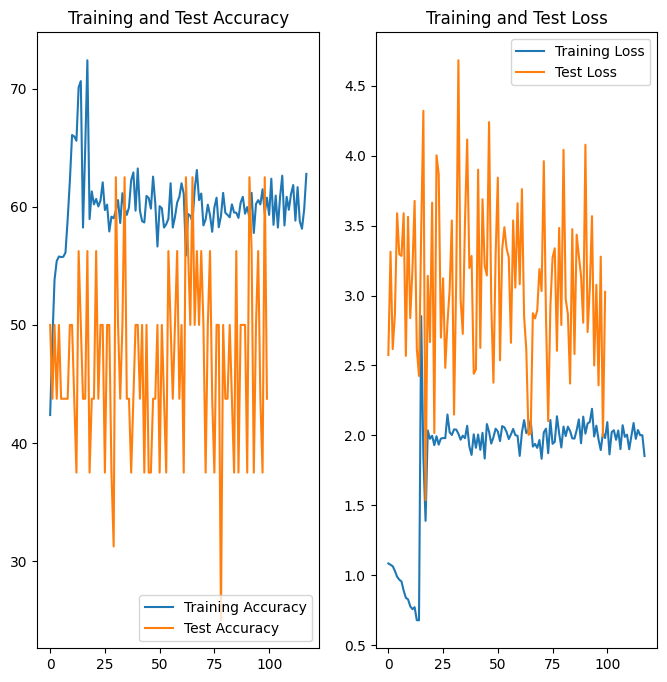

In [ ]:
acc = trainingEpoch_acc
test_acc = validationEpoch_acc

loss = trainingEpoch_loss
test_loss = validationEpoch_loss

epochs_range = range(EPOCHS + add_epoch)
test_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(test_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, torch.tensor(loss).cpu(), label='Training Loss')
plt.plot(test_range, torch.tensor(test_loss).cpu(), label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.show()


step: 0
predict: tensor([1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1], device='cuda:0') accuracy: 37.5 loss: 4.104960918426514
targets: tensor([0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')


step: 1
predict: tensor([1, 2, 2, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') accuracy: 62.5 loss: 1.9929131269454956
targets: tensor([0, 2, 2, 0, 0, 0, 0, 2, 0, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')


step: 2
predict: tensor([1, 0, 2, 1, 2, 1, 0, 1, 1, 2, 1, 0, 1, 2, 1, 1], device='cuda:0') accuracy: 62.5 loss: 1.9999254941940308
targets: tensor([1, 0, 2, 0, 2, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0], device='cuda:0')


step: 3
predict: tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2], device='cuda:0') accuracy: 62.5 loss: 1.4395604133605957
targets: tensor([1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1, 1, 1, 2], device='cuda:0')


step: 4
predict: tensor([1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 1, 0, 1, 0], device='cuda:0') accuracy: 50.0 loss: 2.8753550052642822
targets: tensor([1, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0], device='cuda:0')


step: 5
predict: tensor([2, 1, 0, 0, 1, 1, 1, 2, 0, 1, 1, 1, 0, 1, 2, 1], device='cuda:0') accuracy: 75.0 loss: 2.143679141998291
targets: tensor([2, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 2, 0], device='cuda:0')


step: 6
predict: tensor([1, 1, 1, 2, 2, 1, 1, 0, 0, 1, 0, 1, 1, 1, 2, 2], device='cuda:0') accuracy: 43.75 loss: 2.4509811401367188
targets: tensor([0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 2], device='cuda:0')
step: 7
predict: tensor([0, 1, 1, 1, 1, 0, 2], device='cuda:0') accuracy: 57.14285714285714 loss: 3.243948221206665
targets: tensor([0, 0, 0, 1, 1, 0, 0], device='cuda:0')


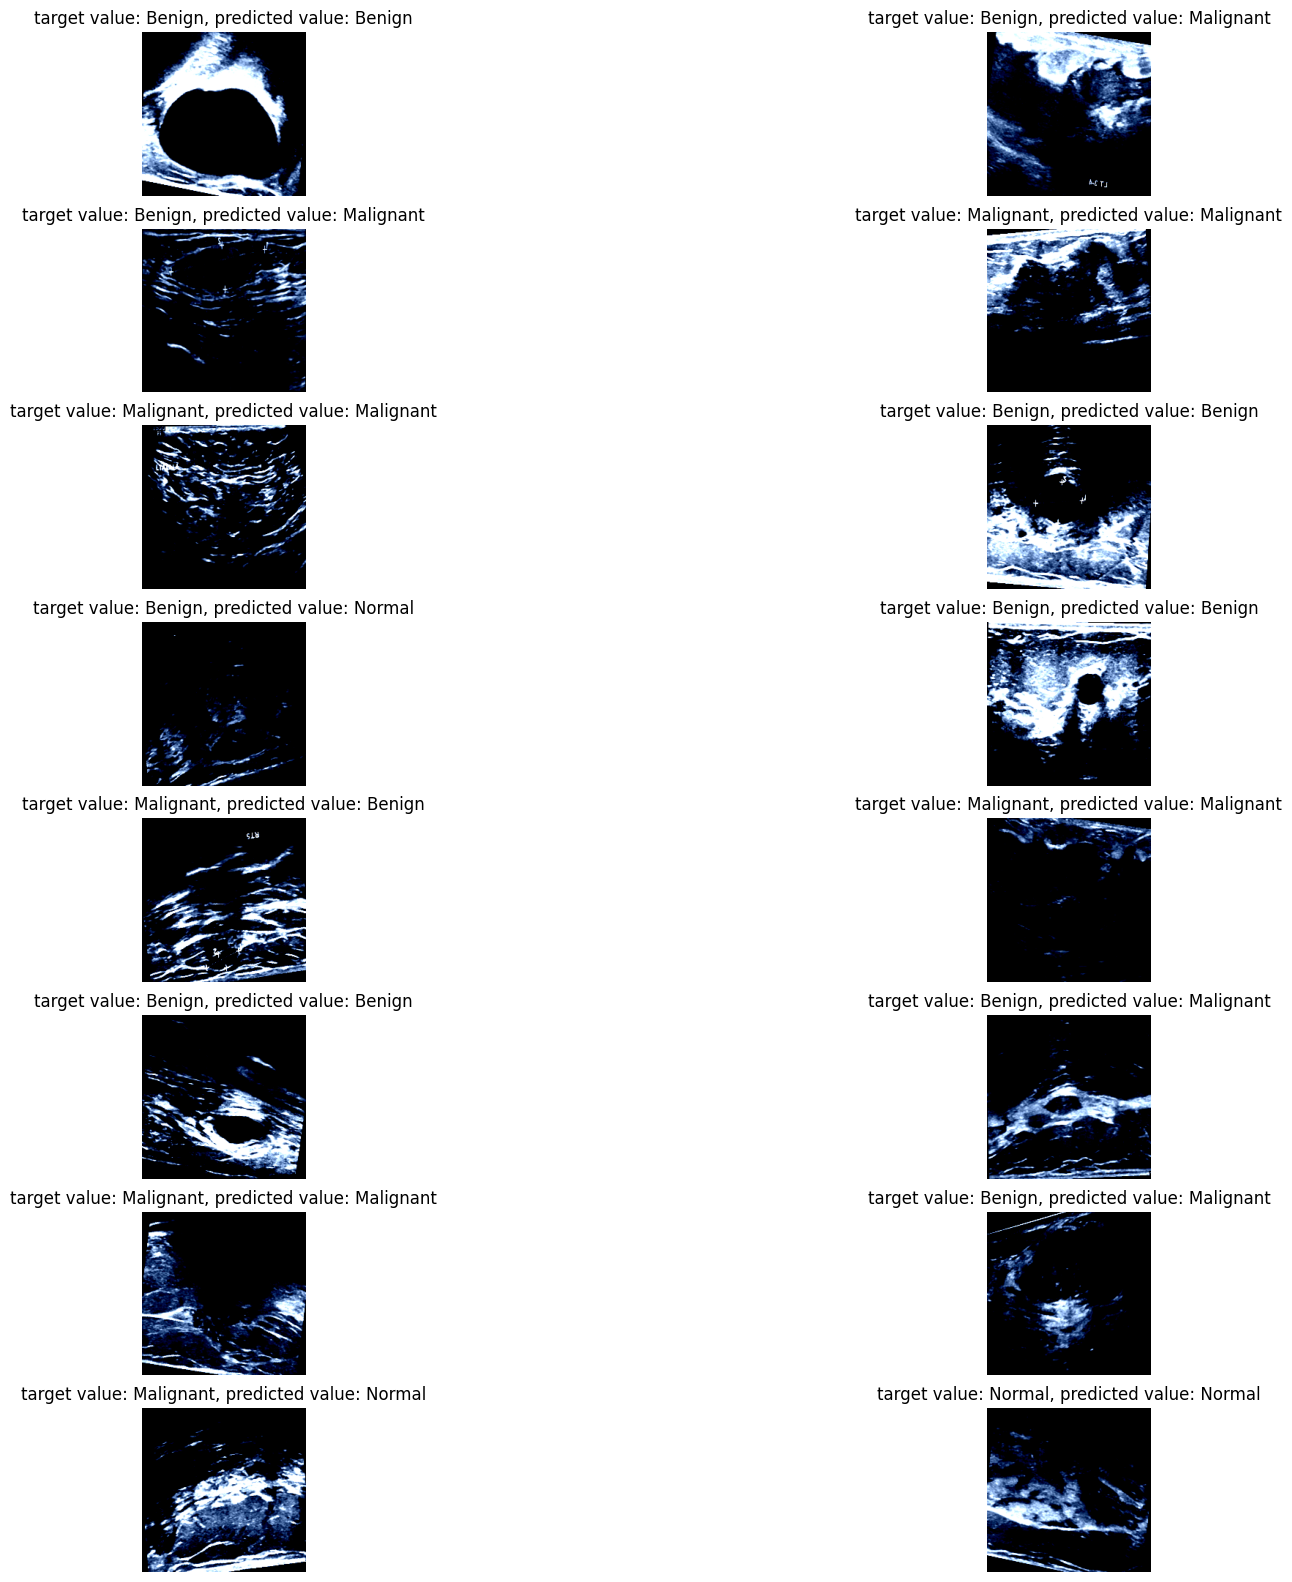

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import models

# Load the state dictionary into the model
best_test_model = torch.load('/content/working/best_test_model.pth')
best_test_model.eval() # Set the model to evaluation mode

EVAL_BATCH = 16
eval_loader = data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

plt.figure(figsize=(20, 20))

# Disable grad
with torch.no_grad():
    for step, (x, y) in enumerate(eval_loader):
    #eval = next(iter(eval_loader))
        #x, y = eval
        x = x.to(device)
        y = y.to(device)
        eval_output, loss = best_test_model(x, y)
        eval_predictions = eval_output.argmax(1)
        acc_value = (eval_predictions == y)
        accuracy = acc_value.sum().item() / len(acc_value) * 100
        print(f"step: {step}")
        print(f"predict: {eval_predictions} accuracy: {accuracy} loss: {loss}")
        print(f"targets: {y}")


        i = 0
        for i in range(eval_predictions.shape[0]):
            value_predicted = "Benign" if eval_predictions[i].item() == 0 else "Malignant" if eval_predictions[i].item() == 1 else "Normal"
            value_target = "Benign" if y[i].item() == 0 else "Malignant" if y[i].item() == 1 else "Normal"

            image = x[i].cpu()
            ax = plt.subplot(int(EVAL_BATCH/2), int(EVAL_BATCH/8), i + 1)
            plt.imshow(image.permute(1, 2, 0))
            plt.title(f"target value: {value_target}, predicted value: {value_predicted}")
            ax.set_axis_off()


tf.Tensor(
[[2 2 1]
 [0 2 0]
 [0 0 0]], shape=(3, 3), dtype=int32)


Text(0.5, 47.7222222222222, 'Predicted Labels')

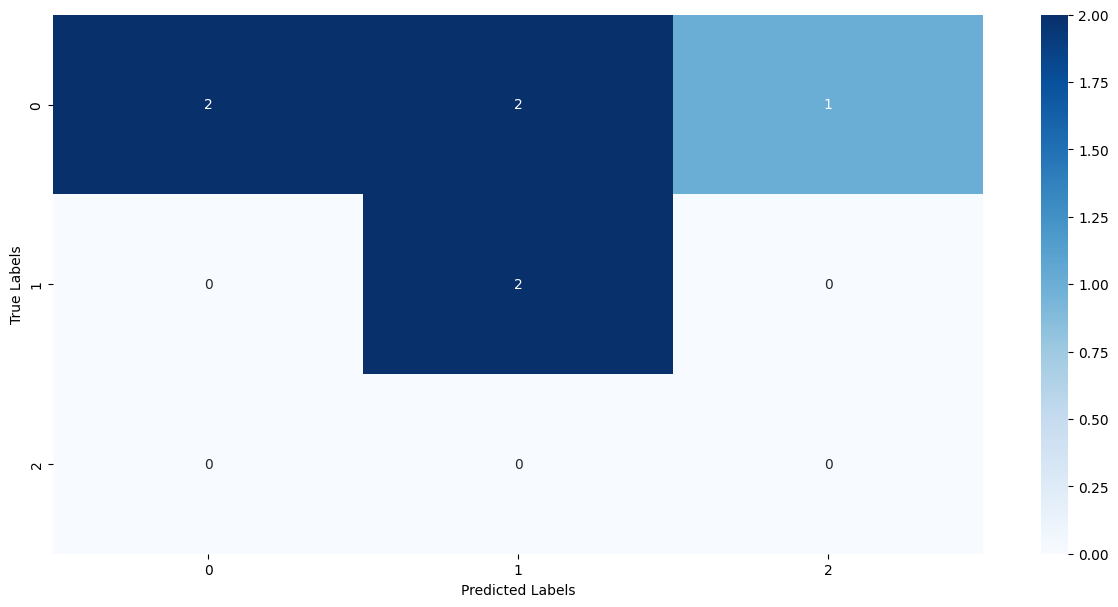

In [ ]:
from tensorflow.math import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y.cpu(), eval_predictions.cpu())
print(conf_mat)
plt.figure(figsize=(15,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
